<a href="https://colab.research.google.com/github/BBulMushroom/CIFAR_10_classification/blob/5Layers/CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cifar10 image classification**
******************************************
**점수관련**  
본 프로젝트는 Accuracy 점수와 보고서를 성적에 반영할 예정입니다. 평가 항목은 아래와 같습니다. 

A. 결과 (40%)
- Metric 성능 :(이미지 분류 - Accuracy)

B. 신규성 (30%)
- Network 변경 내용 - **필수**
- 성능 개선 및 overfitting 방지 시도 (ex. train validation split)

C. 이론적 근거 (20%)
- 기존 baseline과의 차별점 
- 성능 개선을 위한 시도와 이유

D. 보고서 완성도 (10%)

******************************************
**보고서**
1. 연구 목적
2. 모델 구조
3. 실험 내용
4. 실험 결과
5. 고찰 및 결론
6. Colab 파일 (동작 가능여부)

제출하실 파일은 **주피터 노트북 파일**('.ipynb',파일>다운로드)과 **결과 보고서**(pdf)입니다.
******************************************
**코드 검증**  
- 코드 성능 평가(metric)는 torchvision.datasets에 있는 cifar10의 testset을 사용해 Accuracy로 평가합니다.
- pretrain 모델 사용 불가능합니다.

또한 Random 라이브러리 사용시에 seed 고정하는 등 재현을 고려하시고 코딩부탁드립니다. 
******************************************
**GPU 사용 법**  
런타임 > 런타임 유형 변경 > 하드웨어 가속기에서 GPU를 선택하면 GPU를 사용 할 수 있습니다.  
******************************************
**Colab 사용시 유의사항**  
12시간 단위로 가상머신을 사용할 수 있고 12시간이 지나면 모든 파일과 작업로그들이 초기화 됩니다. 또한, 12시간 넘게 GPU를 사용하기는 어려우니 일찍 시작하셔서 틈틈히 실험해보시는 것을 추천드립니다.


******************************************
**Q?**

In [2]:
# Training

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from google.colab import drive
import time
import random

drive.mount('/content/gdrive')



# 하이퍼 파라미터
EPOCH = 15
batch_size = 100
learning_rate = 0.001
momentum = 0.9
random_seed = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# 시드 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# 분류 Class list
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 이미지 전처리
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Lambda(lambda x: x.rotate(90)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                ])

# Dataset. 변경 불가
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Baseline CNN Network
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # Layer 1 shape:  (32, 32, 3)
    # Conv:           (32, 32, 32)
    # Pool:           (16, 16, 32)
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Layer 2 shape:  (16, 16, 32)
    # Conv:           (16, 16, 64)
    # Pool:           (8, 8, 64)
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Layer 3 shape:  (8, 8, 64)
    # Conv:           (8, 8, 128)
    # Pool:           (4, 4, 128)
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    self.fc1 = nn.Linear(4*4*128, 625)
    nn.init.xavier_uniform_(self.fc1.weight)
    self.layer4 = nn.Sequential(
        self.fc1,
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.fc2 = nn.Linear(625, 10)
    nn.init.xavier_uniform_(self.fc2.weight)

    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1)   # Flatten them for FC
    out = self.layer4(out)
    out = self.fc2(out)

    return out

# Network 선언
net = Net().to(device)

# criterion. 변경 '가능'
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=momentum)

loss_ = []
n = len(trainloader)

# Training
for epoch in range(EPOCH): 

  running_loss = 0.0
  start = time.time()
  for i, data in tqdm(enumerate(trainloader, 0)):
    
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

    optimizer.zero_grad() # 배치마다 optimizer 초기화
    outputs = net(inputs)
    loss = criterion(outputs, labels) # 크로스 엔트로피 손실함수 계산 
    
    loss.backward() # backpropagation
    optimizer.step() # 가중치 최적화

    running_loss += loss.item()
  
  torch.save(net.state_dict() ,'/content/gdrive/Shareddrives/전자공학종합설계/5layers model//model_ckpt.pt') # 모델 저장, path 수정
  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))
  print("epoch time :", time.time()-start)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda:0 is available
Files already downloaded and verified
Files already downloaded and verified


500it [00:29, 17.04it/s]


[1] loss: 2.044
epoch time : 30.67845582962036


500it [00:29, 16.93it/s]


[2] loss: 1.696
epoch time : 29.57554841041565


500it [00:29, 17.06it/s]


[3] loss: 1.501
epoch time : 29.36887550354004


500it [00:29, 17.02it/s]


[4] loss: 1.400
epoch time : 29.426449298858643


500it [00:29, 17.08it/s]


[5] loss: 1.319
epoch time : 29.316187858581543


500it [00:29, 16.88it/s]


[6] loss: 1.259
epoch time : 29.663942098617554


500it [00:29, 16.97it/s]


[7] loss: 1.201
epoch time : 29.50517702102661


500it [00:29, 16.87it/s]


[8] loss: 1.152
epoch time : 29.682703495025635


500it [00:29, 16.94it/s]


[9] loss: 1.112
epoch time : 29.556763887405396


500it [00:29, 16.94it/s]


[10] loss: 1.074
epoch time : 29.552838802337646


500it [00:29, 16.86it/s]


[11] loss: 1.035
epoch time : 29.705296277999878


500it [00:29, 16.80it/s]


[12] loss: 1.004
epoch time : 29.81242871284485


500it [00:29, 16.83it/s]


[13] loss: 0.974
epoch time : 29.755008935928345


500it [00:29, 16.83it/s]


[14] loss: 0.946
epoch time : 29.747950792312622


500it [00:29, 16.72it/s]

[15] loss: 0.925
epoch time : 29.94327449798584


# Evaluation

In [3]:
# Evaluation

# 수정
net = Net()
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/Shareddrives/전자공학종합설계/5layers model//model_ckpt.pt')) # 저장된 모델 불러오기


# 이하 전체 수정 불가
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the 10000 test images: 65 %
Accuracy for class plane is: 70.7 %
Accuracy for class car   is: 82.4 %
Accuracy for class bird  is: 50.3 %
Accuracy for class cat   is: 47.1 %
Accuracy for class deer  is: 42.0 %
Accuracy for class dog   is: 65.7 %
Accuracy for class frog  is: 74.1 %
Accuracy for class horse is: 71.3 %
Accuracy for class ship  is: 81.2 %
Accuracy for class truck is: 73.5 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


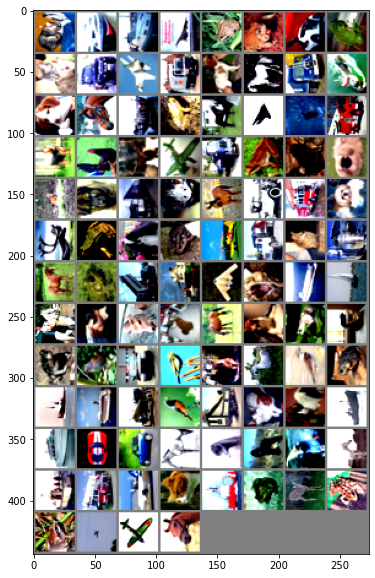

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:  truck   car   car  frog plane   car   car   car


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

net = Net()
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/Shareddrives/전자공학종합설계/5layers model//model_ckpt.pt'))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))